<a href="https://colab.research.google.com/github/bborisggg/hw_econometrics/blob/main/hw_econometrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [463]:
!rm -rf hw_econometrics

In [464]:
!git clone https://github.com/bborisggg/hw_econometrics

Cloning into 'hw_econometrics'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 70 (delta 21), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (70/70), 839.11 KiB | 11.65 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [465]:
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
from matplotlib import gridspec

In [466]:
def adf_test(timeseries, maxlag=None, regression='c', autolag='AIC'):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, maxlag=maxlag, regression=regression, autolag=autolag)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries, maxlag='auto', regression='c'):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression=regression, nlags=maxlag)
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

Опираемся на одну из возможных спецификаций модели:

https://doi.org/10.1108/IJOEM-10-2018-0551

Берем из статьи набор переменных

$$X_t = (\Delta oilp_t ; ygap_t ; \Delta ms_t ; \Delta ir_t ; \Delta er_t; \Delta cpi_t)'$$

Отсюда берем данные по цене на нефть марки Brent
https://fred.stlouisfed.org/series/MCOILBRENTEU

<Axes: xlabel='date'>

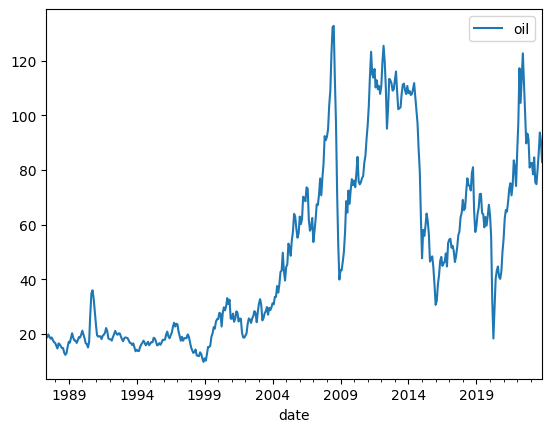

In [467]:
oil = pd.read_excel('hw_econometrics/data/MCOILBRENTEU.xls',skiprows=10)
oil = oil.rename(columns={'observation_date':'date','MCOILBRENTEU':'oil'})
oil = oil.set_index('date')
oil.index = pd.PeriodIndex(oil.index, freq='M')
oil.plot()

<Axes: xlabel='date'>

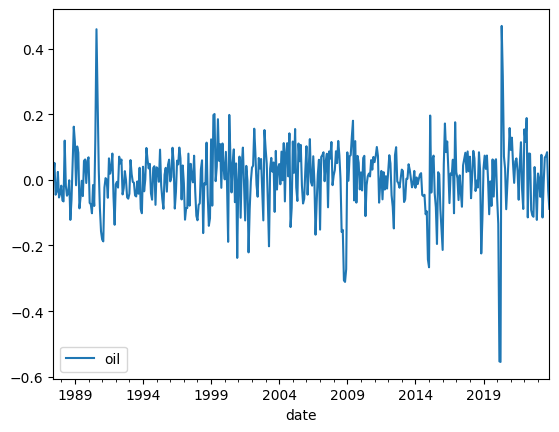

In [468]:
d_oil = (np.log(oil)-np.log(oil.shift(1))).iloc[1:]
d_oil.plot()

In [469]:
adf_test(d_oil, maxlag=12, regression='c', autolag='BIC')

Results of Dickey-Fuller Test:
Test Statistic                -1.440453e+01
p-value                        8.400541e-27
#Lags Used                     1.000000e+00
Number of Observations Used    4.360000e+02
Critical Value (1%)           -3.445438e+00
Critical Value (5%)           -2.868192e+00
Critical Value (10%)          -2.570313e+00
dtype: float64


Можем считать, что ряд стационарен

Ряд разрыва выпуска можем получить из данных по индексу промышленного производства Росстата
Источник:
https://fedstat.ru/indicator/43046
https://fedstat.ru/indicator/57806

<Axes: xlabel='date'>

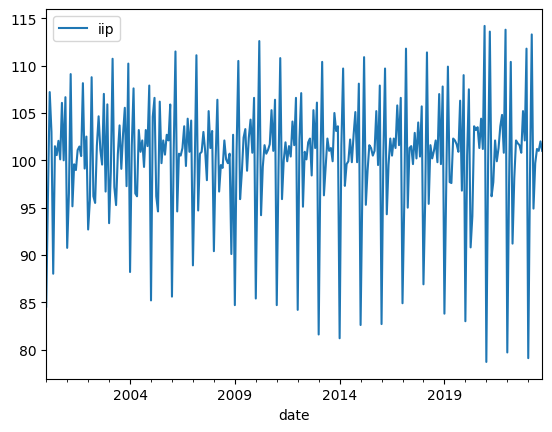

In [470]:
iip = pd.read_excel('hw_econometrics/data/iip_russia.xlsx')
iip = iip.set_index('date')
iip.index = pd.PeriodIndex(iip.index, freq='M')
iip.plot()

У нас есть цепной индекс изменений. Хотим перейти к базисному индексу

In [471]:
iip = (iip/100).cumprod()

In [472]:
prev_index = iip.index
iip.index = iip.index.strftime('%Y:%m')

In [473]:
iip.to_excel('iip_unadjusted.xlsx')

Скачиваем отредактированный файл:

<Axes: xlabel='date'>

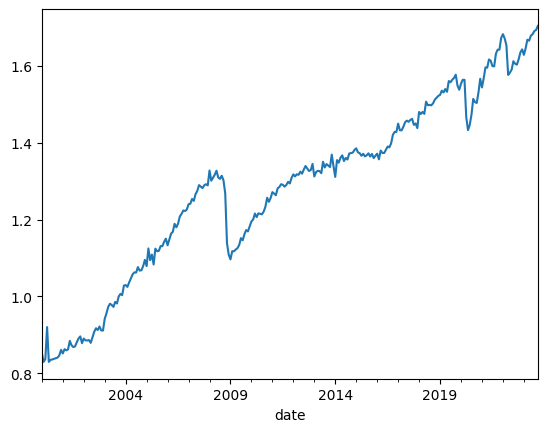

In [474]:
iip = pd.read_excel('hw_econometrics/data/iip_adjusted.xlsx')
iip.index = prev_index
iip = iip['adjusted']
iip.plot()

<Axes: xlabel='date'>

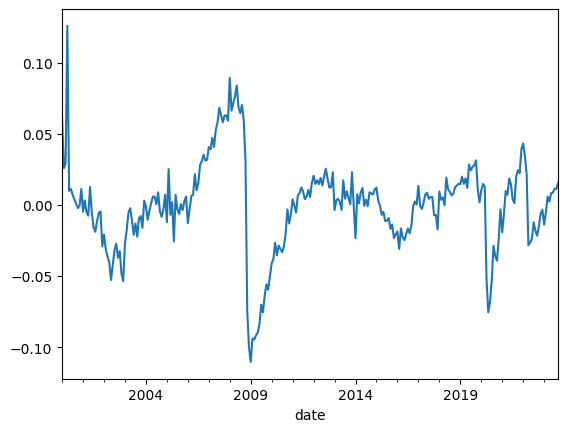

In [475]:
from statsmodels.tsa.filters.hp_filter import hpfilter

cycle, trend = hpfilter(iip, lamb = 129600)
ygap = cycle / trend
ygap.plot()

In [476]:
adf_test(ygap, maxlag=12, regression='c', autolag='BIC')

Results of Dickey-Fuller Test:
Test Statistic                  -4.560716
p-value                          0.000153
#Lags Used                       0.000000
Number of Observations Used    284.000000
Critical Value (1%)             -3.453587
Critical Value (5%)             -2.871771
Critical Value (10%)            -2.572222
dtype: float64


Теперь переходим к монетарной переменной, предложению денег в России. Данные по агрегату M2 предоставляет Банк России.

https://www.cbr.ru/statistics/ms/

In [477]:
ms = pd.read_excel('hw_econometrics/data/monetary_agg.xlsx')
ms = pd.DataFrame({'date':ms.columns[1:],'ms':ms.iloc[12].to_numpy()[1:].astype('float')})
ms = ms.set_index('date')
ms.index = pd.PeriodIndex(ms.index, freq='M')

In [478]:
for_export = ms.copy()
for_export.index = for_export.index.strftime('%Y:%m')
for_export.to_excel('ms_unadjusted.xlsx')

<Axes: xlabel='date'>

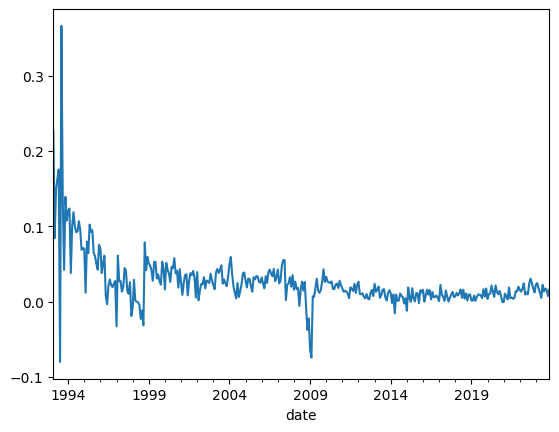

In [479]:
prev_index = ms.index
ms = pd.read_excel('hw_econometrics/data/ms_adjusted.xlsx')
ms.index = prev_index
ms = ms['adjusted']
ms = (np.log(ms)-np.log(ms.shift(1))).iloc[1:]
ms.plot()

In [480]:
adf_test(ms, maxlag=12, regression='c', autolag='BIC')

Results of Dickey-Fuller Test:
Test Statistic                  -5.298143
p-value                          0.000006
#Lags Used                       7.000000
Number of Observations Used    362.000000
Critical Value (1%)             -3.448544
Critical Value (5%)             -2.869557
Critical Value (10%)            -2.571041
dtype: float64


Для вычисления ставки процента могут использоваться различные подходы, в данном случае мы хотим использовать ставку рынка межбанковского кредитования, которую также публикует Банк России

https://www.cbr.ru/hd_base/mkr/

 Средневзвешенные фактические ставки по кредитам в рублях, предоставленным московскими банками
(MIACR - Moscow InterBank Actual Credit Rate)
(в процентах годовых)

Берем однодневные ставки: только по ним есть данные за весь период

In [481]:
ir = pd.read_excel('hw_econometrics/data/ir_russia.xlsx',names=['date','1d','1w','1m','3m','6m','1y'])

<Axes: xlabel='date'>

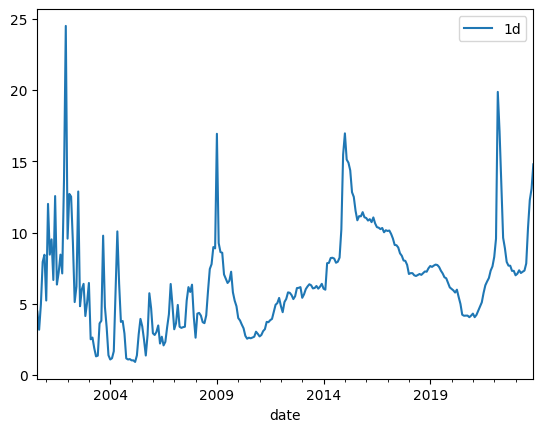

In [482]:
ir = ir[['date','1d']].set_index('date')
ir.index = pd.PeriodIndex(ir.index, freq='M')
ir.plot()

<Axes: xlabel='date'>

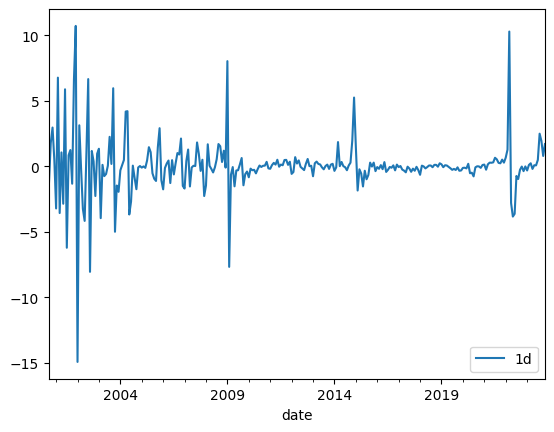

In [483]:
ir = ir.diff().iloc[1:]
ir.plot()

In [484]:
adf_test(ir, maxlag=12, regression='c', autolag='BIC')

Results of Dickey-Fuller Test:
Test Statistic                -1.537169e+01
p-value                        3.501586e-28
#Lags Used                     1.000000e+00
Number of Observations Used    2.770000e+02
Critical Value (1%)           -3.454180e+00
Critical Value (5%)           -2.872031e+00
Critical Value (10%)          -2.572360e+00
dtype: float64


Следующая переменная, номинальный обменный курс. Берем данные с сайте Банка России. Среди особенностей: значения до 1998 необходимо уменьшить в 1000 раз.

https://www.cbr.ru/currency_base/dynamics/

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


<Axes: xlabel='date'>

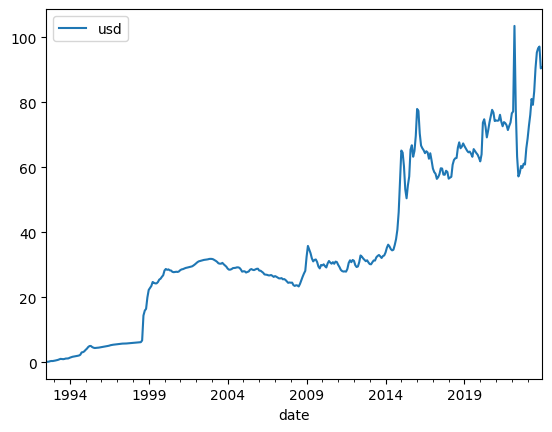

In [485]:
er = pd.read_excel('hw_econometrics/data/usd_rub.xlsx')
er = er[['data','curs']].rename(columns={'data':'date','curs':'usd'}).set_index('date')
er.index = pd.PeriodIndex(er.index, freq='D')
er['1997-12-31':] /= 1000
er = er.resample('M').mean()
er.plot()

<Axes: xlabel='date'>

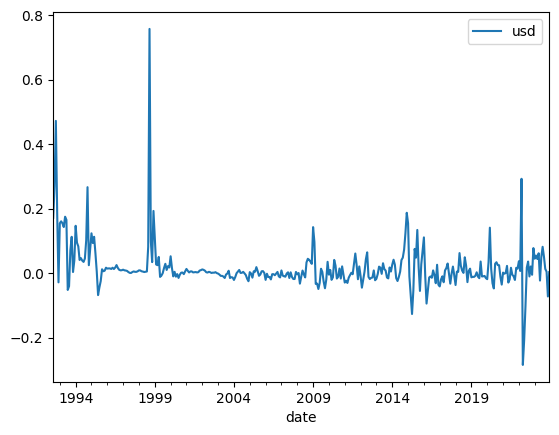

In [486]:
er = (np.log(er)-np.log(er.shift(1))).iloc[1:]
er.plot()

In [487]:
adf_test(er, maxlag=12, regression='c', autolag='BIC')

Results of Dickey-Fuller Test:
Test Statistic                -1.266750e+01
p-value                        1.265446e-23
#Lags Used                     0.000000e+00
Number of Observations Used    3.760000e+02
Critical Value (1%)           -3.447862e+00
Critical Value (5%)           -2.869258e+00
Critical Value (10%)          -2.570881e+00
dtype: float64


Осталось добавить последнюю переменную, данные по инфляции можно получить на сайте Росстата

<Axes: xlabel='date'>

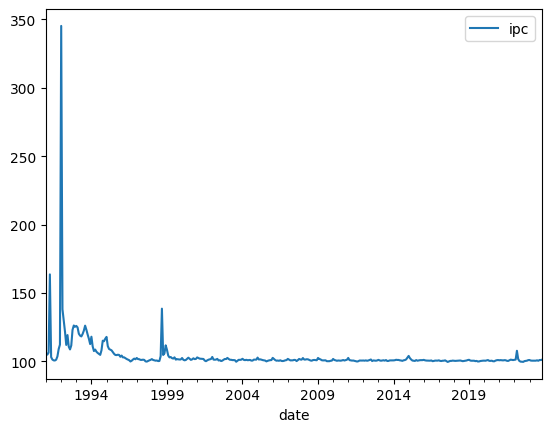

In [488]:
ipc = pd.read_excel('hw_econometrics/data/Ipc_mes-11.xlsx')
ipc = ipc.set_index('date')
ipc.index = pd.PeriodIndex(ipc.index, freq='M')
ipc.plot()

In [489]:
prev_index = ipc.index
ipc.index = ipc.index.strftime('%Y:%m')

In [490]:
ipc.to_excel('ipc_unadjusted.xlsx')

<Axes: xlabel='date'>

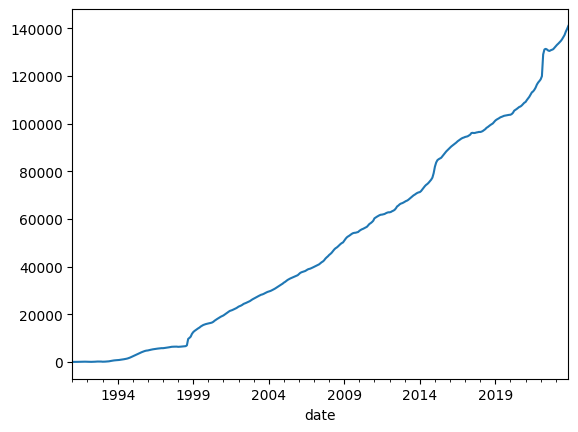

In [491]:
ipc = pd.read_excel('hw_econometrics/data/ipc_adjusted.xlsx')
ipc.index = prev_index
ipc = ipc['adjusted']
ipc.plot()

In [492]:
ipc

date
1991-01       -48.611241
1991-02       -55.026329
1991-03       -49.019462
1991-04       -40.265140
1991-05       -30.132323
               ...      
2023-07    136336.180219
2023-08    137220.187781
2023-09    138655.546246
2023-10    139769.475002
2023-11    141037.931458
Freq: M, Name: adjusted, Length: 395, dtype: float64